# Metric Learning with WildlifeDatasets

### Install the necessary packages

In [2]:
!pip install --quiet wildlife-datasets wildlife-tools pytorch-metric-learning[with-hooks]
!pip install umap-learn

## Import the packages

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import timm
import torchvision.transforms as T
import logging
import numpy as np
from pathlib import Path

from wildlife_datasets import datasets
from wildlife_datasets.analysis import display_statistics

from wildlife_tools.data import WildlifeDataset
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)

/home/cabidi/miniconda3/envs/wildbook-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cabidi/miniconda3/envs/wildbook-env/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Set up data from wildlife-datasets

In [2]:
def wildlife_dataset_constructor(root: str, dataset_classes: list):
    for d in dataset_classes:
        # Extract string representation of class name
        dname = str(d).split(".")[-1].strip("'>")

        # Retrieve/download the dataset
        d.get_data(Path(root, dname))
        d = d(Path(root, dname))
        
        # Augment dataframe with dataset's true name
        d.df['dataset'] = dname

        # Augment identities to ensure uniqueness between datasets
        d.df['identity'] = dname + "_" + d.df['identity'].apply(str)

        # Augment unique integer id for torch purposes
        d.df['uuid'] = dname + "_" + d.df['identity'].apply(str)

        # Augment image paths with root path
        d.df['path'] =  d.df['path'].apply(lambda x: Path(root, dname, x))

        yield d

We will now combine several ```wildlife_dataset.dataset``` objects into a single ```wildlife_tools.WildlifeDataset```. There are some subtle but important differences between these two classes that make working with them (and putting into MiewIdDataset format) a bit wonky.

In [3]:
D = wildlife_dataset_constructor(
    root = "wbia_miew_id/examples/wildlife_datasets",
    dataset_classes = [
        datasets.AerialCattle2017,
        datasets.BelugaIDv2,
        datasets.StripeSpotter,
        #datasets.SeaTurtleID2022, # requires Kaggle
        # datasets.CTai,
        # datasets.CZoo,
        # datasets.CowDataset,
        # datasets.DogFaceNet,
        #datasets.MacaqueFaces
    ]
)

# Combine dataframes and put into a single WildlifeDataset
dfs = pd.concat([d.df for d in D])
transform = T.Compose([
                        T.ToPILImage(),
                        T.Resize([224, 224]),
                        T.ToTensor(),
                        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                    ])
dataset_full = WildlifeDataset(dfs, img_load='crop_black', transform=transform)

# Sanity checks
assert len(dfs['identity'].unique()) == len(np.unique(dataset_full.labels)), "The number of unique individuals must be identical between the dataframes and WildlifeDataset objects"

DATASET AerialCattle2017: DOWNLOADING STARTED.
You are trying to download an already downloaded dataset.
        This message may have happened to due interrupted download or extract.
        To force the download use the `force=True` keyword such as
        get_data(..., force=True) or download(..., force=True).
        
DATASET BelugaIDv2: DOWNLOADING STARTED.
You are trying to download an already downloaded dataset.
        This message may have happened to due interrupted download or extract.
        To force the download use the `force=True` keyword such as
        get_data(..., force=True) or download(..., force=True).
        
DATASET StripeSpotter: DOWNLOADING STARTED.
You are trying to download an already downloaded dataset.
        This message may have happened to due interrupted download or extract.
        To force the download use the `force=True` keyword such as
        get_data(..., force=True) or download(..., force=True).
        


array([[<Axes: title={'center': 'identity'}, xlabel='dataset,identity'>]],
      dtype=object)

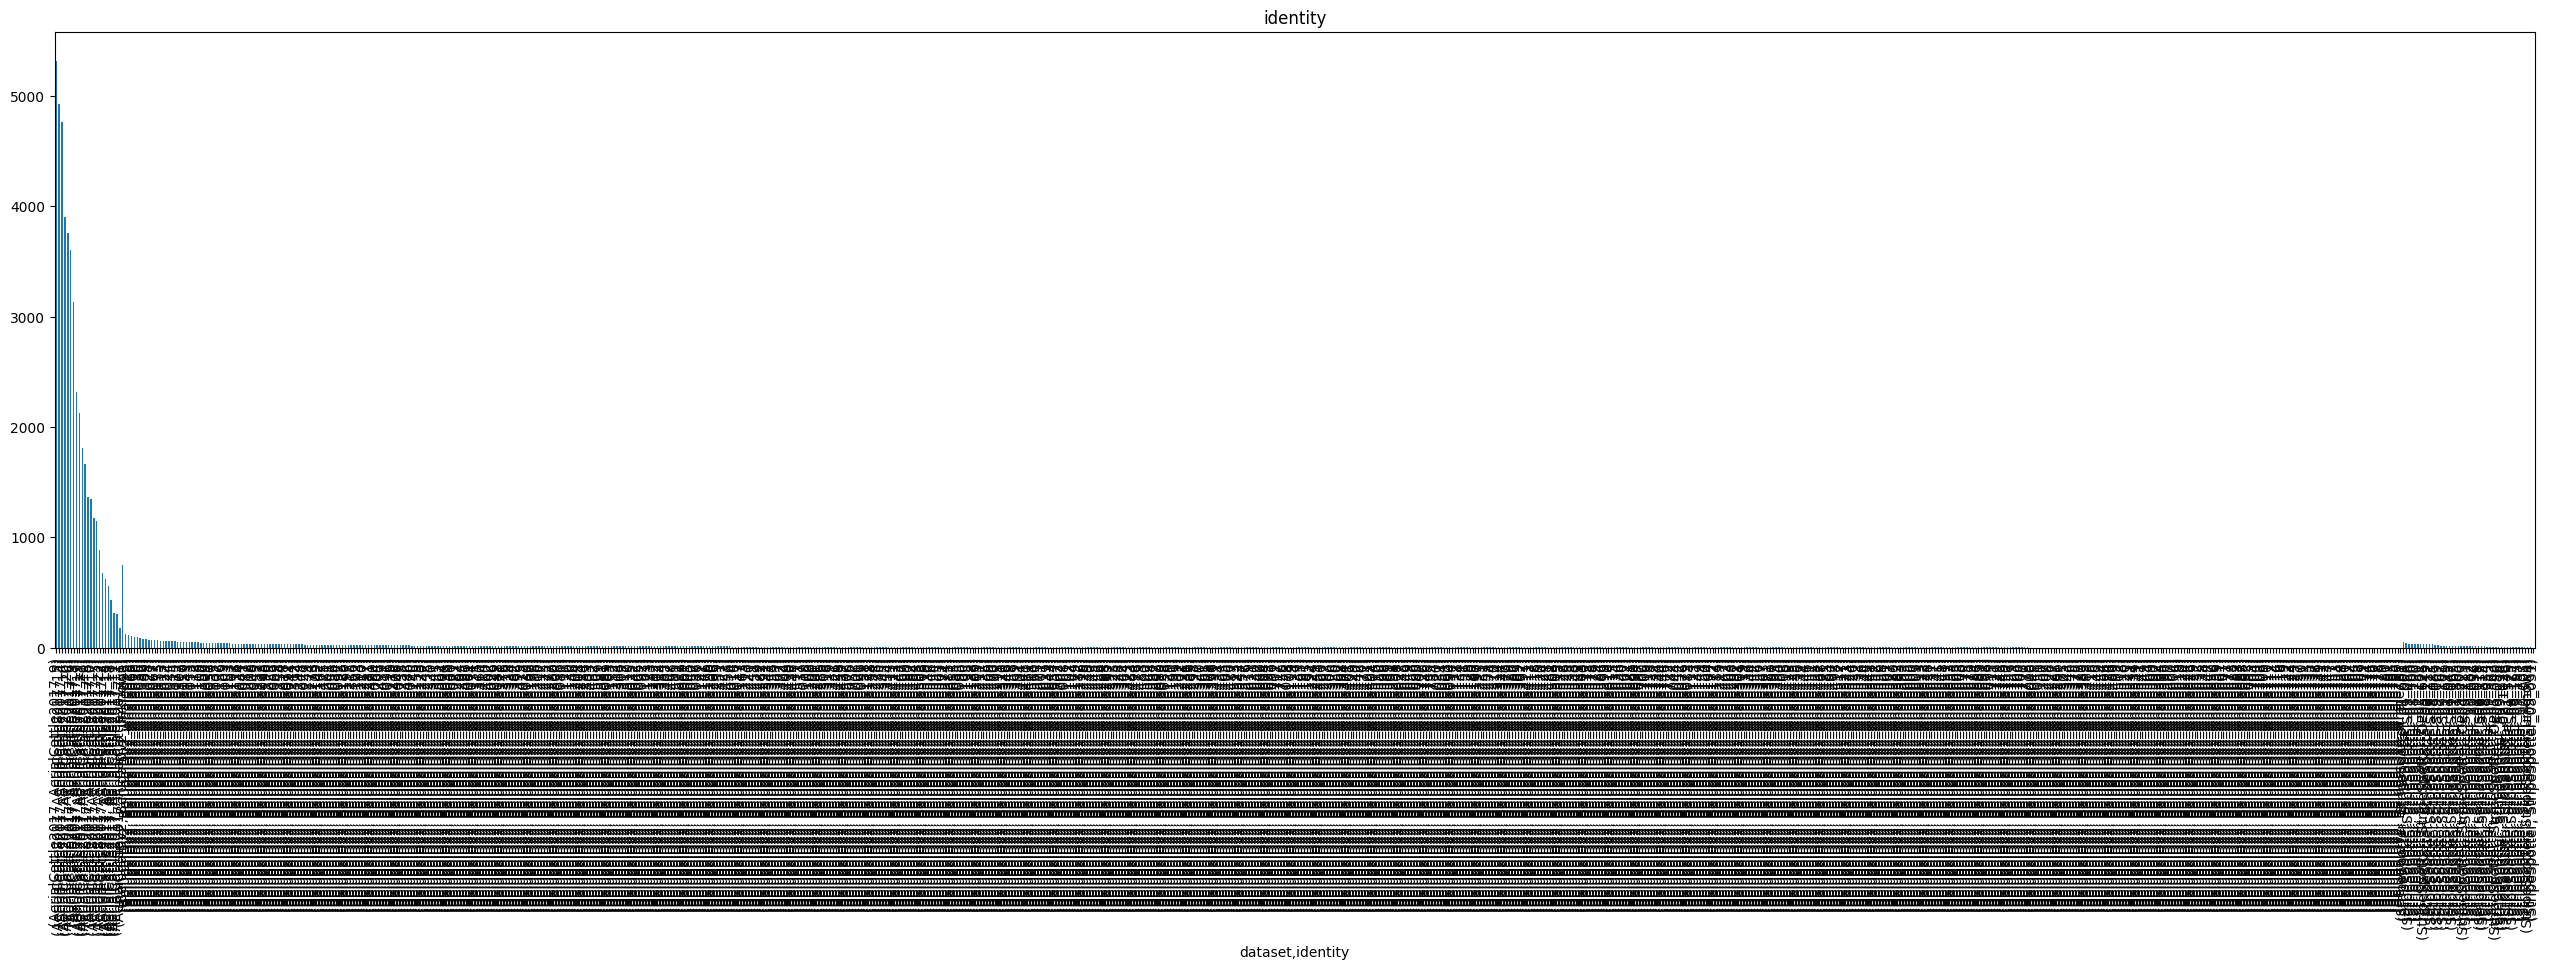

In [5]:
# Plot the counts of each unique individual
plt.figure(figsize=(32,8))
dfs.groupby('dataset')['identity'].value_counts().plot(kind='bar', subplots=True, layout=(-1, 1), figsize=(10, 8), sharex=False, legend=False)

# Train a model

### Model: MegaDescriptor + KNN

Now that we have united several datasets from ```wildlife-datasets``` into a single dataframe, let's try to train a simple model from ```wildlife_tools```.

In [5]:
# Set up feature extractor from MegaDescriptor
model_name = 'hf-hub:BVRA/MegaDescriptor-T-224'
model = timm.create_model(model_name, num_classes=0, pretrained=True)
transform = T.Compose([T.Resize([224, 224]), T.ToTensor(), T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
extractor = DeepFeatures(model, device="cuda")

# Extract two unique individuals
df_a = dfs[dfs['identity'] == "AerialCattle2017_21"]
df_b = dfs[dfs['identity'] == "ATRW_220"]

# Form database/query split
df_database = pd.concat((df_a.iloc[2:], df_b.iloc[2:]))
df_query = pd.concat((df_a.iloc[:2], df_b.iloc[:2]))

# Form datasets from database/query splits
d_database = WildlifeDataset(df_database, transform=transform, img_load='crop_black')
d_query = WildlifeDataset(df_query, transform=transform, img_load='crop_black')

# Extract features for database and queries
database = extractor(d_database)
print(f"Database: {database.shape}")
query = extractor(d_query)
print(f"Query: {query.shape}")

# Compute cosine similarity pairwise between features in query and features in database
similarity_function = CosineSimilarity()
similarity = similarity_function(query, database)['cosine']

# Build a KNN classifier from the database
classifier = KnnClassifier(k=1, database_labels=d_database.labels_string)
predictions = classifier(similarity)
print(f"KNN predictions: {predictions}")

# Get top-5 matches
idx = (-similarity).argsort(axis=-1)[:, :5]
idx_true = df_query.index
idx_pred = df_database.index.to_numpy()[idx]

/home/cabidi/miniconda3/envs/wildbook-env/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, 

Database: (1809, 768)


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


Query: (2, 768)
KNN predictions: ['AerialCattle2017_21' 'AerialCattle2017_21']


### K-Means Clustering

Let's now train a K-means classifier from Faiss.

In [9]:
import torch
from pytorch_metric_learning.utils.inference import FaissKMeans

# Set up Faiss kmeans clustering algorithm
kmeans_func = FaissKMeans(niter=100, verbose=True, gpu=True)

# Extract embeddings for all individuals
X = extractor(dataset_full)

# Cluster embeddings into one cluster per individual
num_individuals = len(np.unique(dataset_full.labels))
cluster_assignments = kmeans_func(torch.Tensor(X), num_individuals)

  0%|                                                                       | 0/405 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 405/405 [08:22<00:00,  1.24s/it]


Clustering 51755 points in 768D to 205 clusters, redo 1 times, 100 iterations
  Preprocessing in 0.03 s
  Iteration 99 (1.48 s, search 0.93 s): objective=2.72794e+06 imbalance=1.618 nsplit=0       


In [10]:
y_hat = np.stack([dataset_full.labels, cluster_assignments.numpy()]).T
y_hat

array([[  0,  99],
       [  1, 147],
       [  2, 163],
       ...,
       [189,  96],
       [ 63, 192],
       [102, 192]])

In [11]:
# create a structured array
dtype = [('true label', int), ('predicted cluster', int)]
values = [(y_true, y_pred) for y_true, y_pred in y_hat]
a = np.array(values, dtype=dtype)

# sort by true label
a_sorted = np.sort(a, order='true label')
a_sorted

array([(  0,   9), (  0,   9), (  0,   9), ..., (204, 201), (204, 201),
       (204, 201)],
      dtype=[('true label', '<i8'), ('predicted cluster', '<i8')])

In [12]:
a_sorted['true label']

array([  0,   0,   0, ..., 204, 204, 204])

In [13]:
np.split(a_sorted, np.unique(a_sorted['true label']))[2]

array([(0, 9)],
      dtype=[('true label', '<i8'), ('predicted cluster', '<i8')])

### WildLife Dataset -> MiewID Dataset

Let's try to adapt the ```WildLifeDataset``` objects into a ```MiewIdDataset``` object to train a ```MiewID``` model.

In [11]:
import torch
from wbia_miew_id.datasets.helpers import load_image
from wbia_miew_id.datasets import MiewIdDataset

class WildLifeToMiewidAdapter(MiewIdDataset):
    """Adapts a WildLife dataset to a MiewID dataset."""
    def __init__(
            self,
            wildlife_dataset: WildlifeDataset,
            csv,
            transforms=None,
            fliplr=False,
            fliplr_view=[],
            crop_bbox=False,
            n_train_classes=None
        ) -> None:
        self.wildlife_dataset = wildlife_dataset
        self.csv = csv#.reset_index()
        self.augmentations = transforms
        self.fliplr = fliplr
        self.fliplr_view = fliplr_view
        self.crop_bbox = crop_bbox
        self.n_train_classes = n_train_classes

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        # Extract row of observation
        row = self.csv.iloc[index]

        # Extract features
        image_path = row['path']
        image = load_image(image_path)

        # Apply transformations
        if self.augmentations:
            image = self.augmentations(image)

        # Extract label
        label = torch.tensor(self.wildlife_dataset.labels[index])

        # Extract image index
        image_idx = self.csv.index[index]

        # Combine features into a dictionary
        return {
            "image":        image,
            "label":        label,
            "image_idx":    image_idx,
            #"file_path":    image_path,
            #"date":         row['date'],
            #"category":     row['dataset']
        }

In [12]:
d = WildLifeToMiewidAdapter(
    dataset_full,
    dfs,
    transforms=dataset_full.transform
)

# Construct train + val loaders using the MacaqueFaces dataset
train_loader = torch.utils.data.DataLoader(
    d,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    d,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [ ]:
### Training technique a: train a MiewID model
### Training technique b: train something else that's dumb
### Training technique c: train something else that's not dumb

In [ ]:
### Try feeding Wildlife Tools dataset into GradCamPlusPlus and see if it just works

# Set up feature extractor from MegaDescriptor
model_name = 'hf-hub:BVRA/MegaDescriptor-T-224'
model = timm.create_model(model_name, num_classes=0, pretrained=True)
transform = T.Compose([T.Resize([224, 224]), T.ToTensor(), T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
extractor = DeepFeatures(model, device="cuda")

# Set up GradCamPlusPlus